In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
def load_data(L,temp,MCS):
    return np.fromfile(f"../ising_wolff/dataIsing2D_L{L}/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)

In [133]:
Tmin = 2.27
Tmax = 3.22
meas = 20
Ts = np.linspace(Tmin,Tmax,meas)
L = 8
data = load_data(L,Ts[9],200000)

$\mathbf{A} = \mathbf{W} + g\left[\mathbf{M}\mathbf{W}-\mathbf{1} \right]$


$\mathbf{W} = \left(\Delta_t \mathbf{1} + \mathbf{C}^0 e^{-2t}\right)^{-1}$

$\mathbf{M} = 3\Delta_t \left[\mathbf{C}^0 e^{-2t} + \left(\Delta_t + e^{-2t}\right) \mathbf{1}\right]$

The equation for $g$ is:

$\text{Tr}(\mathbf{A}(\mathbf{M}-\mathbf{W}^{-1})) - g \cdot\text{Tr}(x_i^2  (x_i^2-1)^2) + \cdots$ = 0

Let's get the matrix M and W

In [150]:
nSteps =600
dt = 0.01
diffTemp = 4
def Deltat(n,dt,diffTemp):
    return diffTemp*(1-np.exp(-2*(n+1)*dt))

In [151]:
C0 = np.cov(data.T)
W = np.empty((nSteps,data.shape[1],data.shape[1]))
invW = np.empty((nSteps,data.shape[1],data.shape[1]))
M = np.empty((nSteps,data.shape[1],data.shape[1]))
K = np.empty((nSteps,data.shape[1],data.shape[1]))
M = np.empty((nSteps,data.shape[1],data.shape[1]))

In [152]:
for t in range(nSteps):
    Dt = Deltat(t,dt,diffTemp)
    invW[t] = Dt*np.eye(data.shape[1]) + C0*np.exp(-2*(t+1)*dt)
    W[t] = np.linalg.inv(invW[t])
    M[t] = 3*Dt*(C0*np.exp(-2*(t+1)*dt) + np.eye(data.shape[1])*(Dt + np.exp(-2*(t+1)*dt)))

$\mathbf{A}(\mathbf{M}-\mathbf{W}^{-1}) = \mathbf{W}\mathbf{M} - \mathbf{1} + g\cdot (-2\mathbf{M} + \mathbf{W}^{-1} + \mathbf{M}\mathbf{W}\mathbf{M}) = \mathbf{K} + g\cdot \mathbf{K_g}$

$ \mathbf{K} + g\cdot \mathbf{K_g} - g\cdot \mathbf{C}_6  + \mathbf{C_4} = 0$

In [153]:
K = np.matmul(W,M) - np.eye(W.shape[1])
K_g = -2*M + invW + np.matmul(M,np.matmul(W,M))

Now the other terms

In [154]:
ts= np.array([*range(nSteps)])
Dts = Deltat(ts,dt,diffTemp)
expts = np.exp(-2*(ts+1)*dt)
C6 = Dts*(15*Dts**2 - 6*Dts + 1) + expts *(45*Dts**2 - 12*Dts + 1) + expts**2 * (15*Dts-2) + expts**3
C4 = 3*(Dts+expts**2)-1

$g = -\frac{\text{Tr}(\mathbf{K}) - \mathbf{C}_4}{\text{Tr}(\mathbf{K}_g) - \mathbf{C}_6}$

In [155]:
num = np.trace(K,axis1=1,axis2=2) - 100*C4
den = np.trace(K_g,axis1=1,axis2=2) - 100*C6
g = -num/den

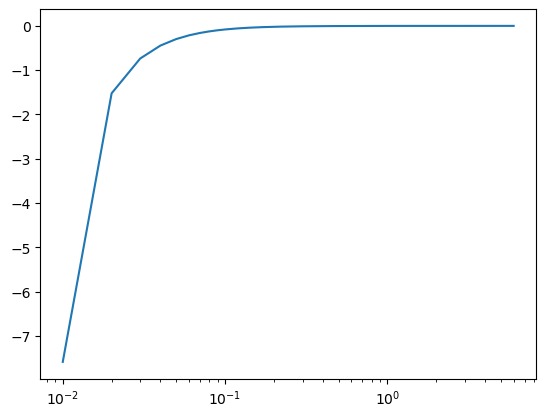

In [156]:
plt.plot((ts+1)*dt,g)
plt.xscale("log")

$\mathbf{A} = \mathbf{W} + g\left[\mathbf{M}\mathbf{W}-\mathbf{1} \right]$


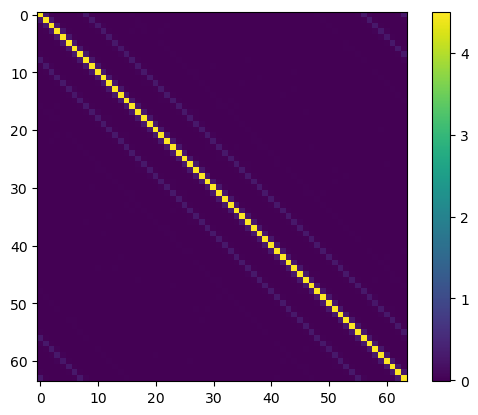

In [157]:
A =  W + g.reshape(nSteps,1,1)*(np.matmul(M,W)-np.eye(data.shape[1]).reshape(1,data.shape[1],data.shape[1]))
plt.imshow(A[0])
plt.colorbar()

In [158]:
def myscore(x,A,g):
    return  -np.matmul(x,A.T) + g*x*(x**2-1)

In [159]:
def backward(xT,A,g,temp,nSteps,dt,full_traj = False,device = "cpu"):
    P = xT.shape[0]
    N = xT.shape[1]
    nbatches = 50
    batch_size = int(P/nbatches)
    if(full_traj):
        x_recon = torch.Tensor(P,nSteps,N)
        x_recon[:,-1,:] = xT
    else:
        x_recon = xT
    with torch.no_grad():
        for tt in range(nSteps)[::-1]:
            std = np.sqrt(2*(temp)*dt)*torch.randn_like(xT)
            den = np.sqrt(temp*(1-np.exp(-2*(tt+1))))
            
            for n in range(nbatches):
                if(full_traj):
                    score = myscore(x_recon[n*batch_size:(n+1)*batch_size,tt,:], A[tt],g[tt])/den
                    x_recon[n*batch_size:(n+1)*batch_size,tt-1,:] = x_recon[n*batch_size:(n+1)*batch_size,tt,:]*(1+dt) + 2*temp*score*dt + std[n*batch_size:(n+1)*batch_size]
                else:
                    score = myscore(x_recon[n*batch_size:(n+1)*batch_size], A[tt],g[tt])/den
                    x_recon[n*batch_size:(n+1)*batch_size] = x_recon[n*batch_size:(n+1)*batch_size]*(1+dt)+ 2*temp*score*dt + std[n*batch_size:(n+1)*batch_size]
                del score
        
    return x_recon

In [160]:
P = 50000
N = L**2
xT = np.sqrt(diffTemp)*torch.randn((P,N))
x_recon = backward(xT,A,g,diffTemp,nSteps,dt).numpy()

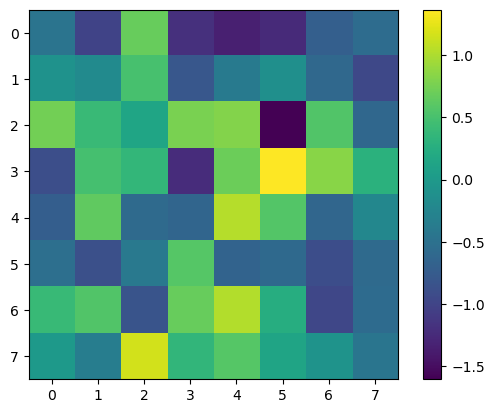

In [161]:
plt.imshow(x_recon[1].reshape(L,L))
plt.colorbar()

(array([0.270625, 0.55285 , 0.652675, 0.51325 , 0.47745 , 0.556675,
        0.508525, 0.6525  , 0.5466  , 0.26885 ]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

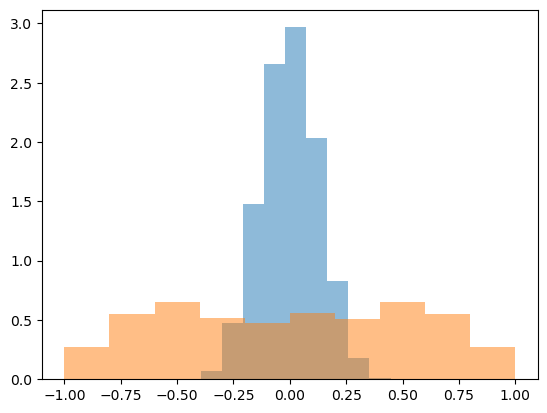

In [162]:
plt.hist(np.mean(x_recon,axis =1),density=True,alpha = 0.5)
plt.hist(np.mean(data,axis =1),density=True,alpha = 0.5)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 5.000e+00, 6.000e+00, 9.000e+00, 1.800e+01, 2.900e+01,
        4.600e+01, 6.000e+01, 1.020e+02, 1.580e+02, 2.320e+02, 3.130e+02,
        4.600e+02, 6.090e+02, 7.520e+02, 9.450e+02, 1.030e+03, 1.240e+03,
        1.417e+03, 1.450e+03, 1.556e+03, 1.557e+03, 1.516e+03, 1.498e+03,
        1.400e+03, 1.347e+03, 1.263e+03, 1.200e+03, 1.033e+03, 9.860e+02,
        9.720e+02, 9.010e+02, 9.140e+02, 9.430e+02, 9.030e+02, 9.410e+02,
        1.045e+03, 1.111e+03, 1.196e+03, 1.254e+03, 1.399e+03, 1.392e+03,
        1.551e+03, 1.589e+03, 1.644e+03, 1.498e+03, 1.402e+03, 1.300e+03,
        1.191e+03, 1.053e+03, 8.690e+02, 7.540e+02, 5.560e+02, 4.360e+02,
        3.320e+02, 1.780e+02, 1.480e+0

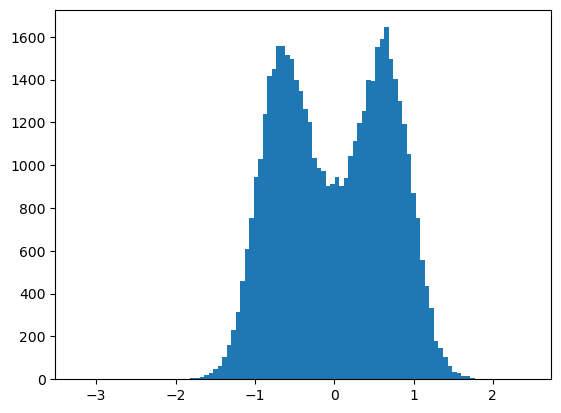

In [163]:
plt.hist(x_recon[:,1],bins = 100)

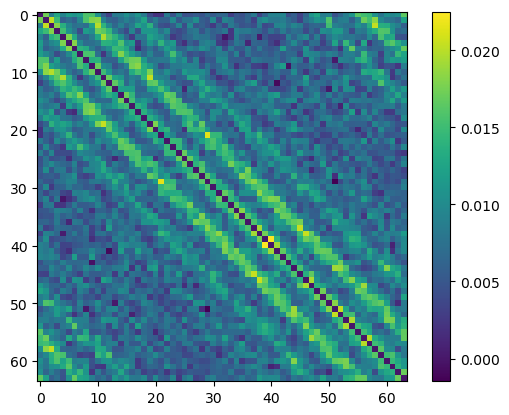

In [164]:
Jrecon = np.cov(x_recon.T)
Jrecon = -Jrecon +np.diag(np.diag(Jrecon))
plt.imshow(-Jrecon)
plt.colorbar()

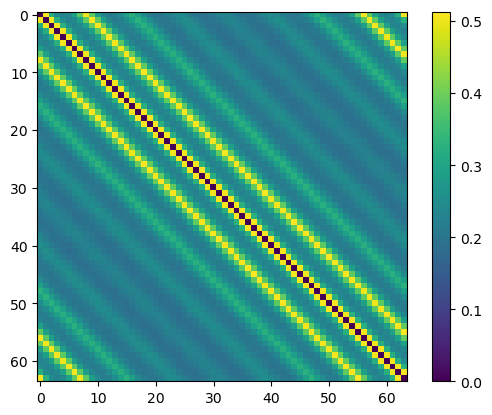

In [165]:
Jtrue = np.cov(data.T)
Jtrue = -Jtrue +np.diag(np.diag(Jtrue))
plt.imshow(-Jtrue)
plt.colorbar()